In [100]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math
import json
%matplotlib inline

# Stanley algorithm

In [43]:
def calculate_next_position(current_position, steering_angle, velocity, dt):
    # current_position: (x, y, theta) tuple
    # steering_angle: angle in radians
    # velocity: scalar value
    # dt: time step
    
    x, y, theta = current_position
    # calculate the turning radius of the vehicle
    turning_radius = velocity / math.tan(steering_angle)
    
    if abs(steering_angle) < 1e-6:
        # if steering angle is close to zero, move straight
        x += velocity * dt * math.cos(theta)
        y += velocity * dt * math.sin(theta)
    else:
        # calculate the center of curvature of the vehicle's path
        cx = x - turning_radius * math.sin(theta)
        cy = y + turning_radius * math.cos(theta)
        # calculate the next position using the kinematic bicycle model
        next_x = cx + turning_radius * math.sin(theta + velocity*dt/turning_radius)
        next_y = cy - turning_radius * math.cos(theta + velocity*dt/turning_radius)
        next_theta = theta + velocity*dt/turning_radius
    
        # ensure that the orientation angle is within the range [-pi, pi]
        next_theta = (next_theta + math.pi) % (2*math.pi) - math.pi
    
        return (next_x, next_y, next_theta)

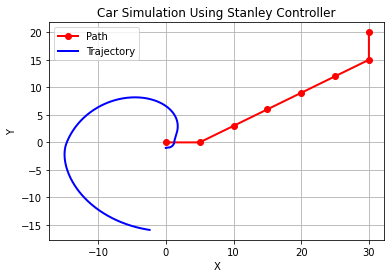

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def stanley_controller(path, current_pose, speed, k_e, k_theta, lookahead_distance):
    dx = path[:, 0] - current_pose[0]
    dy = path[:, 1] - current_pose[1]
    dist = np.sqrt(dx**2 + dy**2)
    closest_idx = np.argmin(dist)

    lookahead_idx = closest_idx
    while lookahead_idx < len(path) - 1:
        if np.linalg.norm(path[lookahead_idx] - current_pose[:2]) > lookahead_distance:
            break
        lookahead_idx += 1

    # Calculate the cross-track error (CTE) with correct sign
    segment_vec = path[closest_idx + 1] - path[closest_idx]
    segment_heading = np.arctan2(segment_vec[1], segment_vec[0])
    pose_vec = current_pose[:2] - path[closest_idx]
    cte_sign = np.sign(np.cross(segment_vec, pose_vec))
    cte = dist[closest_idx] * cte_sign

    # Calculate the heading error
    path_heading = np.arctan2(dy[lookahead_idx], dx[lookahead_idx])
    heading_error = path_heading - current_pose[2]
    heading_error = np.arctan2(np.sin(heading_error), np.cos(heading_error))

    # Calculate the steering angle
    steering_angle = heading_error + np.arctan2(k_e * cte, speed)

    return steering_angle


def simulate_car(path, initial_pose, speed, k_e, k_theta, dt, distance_threshold, max_iterations, lookahead_distance):
    trajectory = [initial_pose]
    current_pose = np.array(initial_pose)
    iteration = 0

    while np.linalg.norm(path[-1] - current_pose[:2]) > distance_threshold and iteration < max_iterations:
        steering_angle = stanley_controller(path, current_pose, speed, k_e, k_theta, lookahead_distance)

        current_pose[0] += speed * np.cos(current_pose[2]) * dt
        current_pose[1] += speed * np.sin(current_pose[2]) * dt
        current_pose[2] += speed / 2.5 * np.tan(steering_angle) * dt

        trajectory.append(current_pose.copy())
        iteration += 1

    return np.array(trajectory)

path = np.array([[0, 0], [5, 0], [10, 3], [15, 6], [20, 9], [25, 12], [30, 15], [30, 20]])
initial_pose = np.array([0, -1, np.pi/18])
speed = 1.0
k_e = 0.5
k_theta = 2.0
dt = 0.1
distance_threshold = 0.1
max_iterations = 500
lookahead_distance = 1.0

trajectory = simulate_car(path, initial_pose, speed, k_e, k_theta, dt, distance_threshold, max_iterations, lookahead_distance)

plt.figure()
plt.plot(path[:, 0], path[:, 1], 'ro-', linewidth=2, label='Path')
plt.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=2, label='Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Car Simulation Using Stanley Controller')
plt.grid(True)
plt.show()


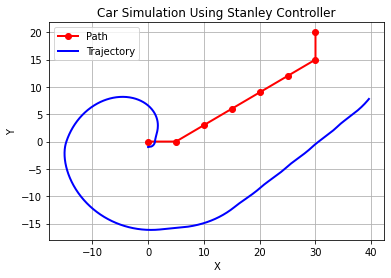

In [45]:
def simulate_car(path, initial_pose, speed, k_e, k_theta, dt, distance_threshold, max_iterations, lookahead_distance):
    """
    Simulates a car driving according to a given path using the Stanley controller.

    Parameters:
    path (numpy array): Nx2 array containing the path points [x, y]
    initial_pose (tuple): A tuple containing the vehicle's initial (x, y, theta) pose
    speed (float): The vehicle's constant speed
    k_e (float): Gain for cross-track error (CTE)
    k_theta (float): Gain for heading error
    dt (float): Time step for the simulation
    distance_threshold (float): Distance from the last waypoint at which the car is considered to have reached its destination
    max_iterations (int): Maximum number of iterations for the simulation

    Returns:
    trajectory (numpy array): A numpy array of shape Nx3 containing the vehicle's (x, y, theta) trajectory
    """
    trajectory = [initial_pose]
    current_pose = np.array(initial_pose)
    iteration = 0

    while np.linalg.norm(path[-1] - current_pose[:2]) > distance_threshold and iteration < max_iterations:
#         steering_angle = stanley_controller(path, current_pose, speed, k_e, k_theta)
        steering_angle = stanley_controller(path, current_pose, speed, k_e, k_theta, lookahead_distance)

        # Update the vehicle's pose using a simple bicycle model
        current_pose[0] += speed * np.cos(current_pose[2]) * dt
        current_pose[1] += speed * np.sin(current_pose[2]) * dt
        current_pose[2] += speed / 2.5 * np.tan(steering_angle) * dt

        trajectory.append(current_pose.copy())
        iteration += 1

    return np.array(trajectory)

# Parameters for the simulation
distance_threshold = 0.1
max_iterations = 1000
# Parameters for the simulation
lookahead_distance = 1.0

# Simulate the car driving along the given path
trajectory = simulate_car(path, initial_pose, speed, k_e, k_theta, dt, distance_threshold, max_iterations, lookahead_distance)

# Plot the path and the vehicle's trajectory
plt.figure()
plt.plot(path[:, 0], path[:, 1], 'ro-', linewidth=2, label='Path')
plt.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=2, label='Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Car Simulation Using Stanley Controller')
plt.grid(True)
plt.show()


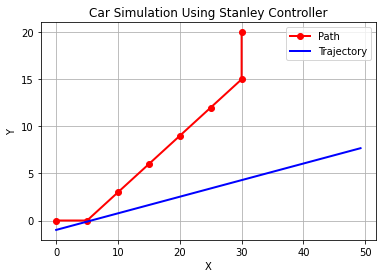

In [229]:
import numpy as np
import matplotlib.pyplot as plt

def stanley_controller(path, current_pose, speed, k_e, k_theta, lookahead_distance):
    return 0
    dx = path[:, 0] - current_pose[0]
    dy = path[:, 1] - current_pose[1]
    dist = np.sqrt(dx**2 + dy**2)
    closest_idx = np.argmin(dist)

    lookahead_idx = closest_idx
    while lookahead_idx < len(path) - 1:
        if np.linalg.norm(path[lookahead_idx] - current_pose[:2]) > lookahead_distance:
            break
        lookahead_idx += 1

    # Calculate the cross-track error (CTE) with correct sign
    segment_vec = path[closest_idx + 1] - path[closest_idx]
    segment_heading = np.arctan2(segment_vec[1], segment_vec[0])
    pose_vec = current_pose[:2] - path[closest_idx]
    cte_sign = np.sign(np.cross(segment_vec, pose_vec))
    cte = dist[closest_idx] * cte_sign

    # Calculate the heading error
    path_heading = np.arctan2(dy[lookahead_idx], dx[lookahead_idx])
    heading_error = path_heading - current_pose[2]
    heading_error = np.arctan2(np.sin(heading_error), np.cos(heading_error))

    # Calculate the steering angle
    steering_angle = heading_error + np.arctan2(k_e * cte, speed)

    return steering_angle


def simulate_car(path, initial_pose, speed, k_e, k_theta, dt, distance_threshold, max_iterations, lookahead_distance):
    trajectory = [initial_pose]
    current_pose = np.array(initial_pose)
    iteration = 0

    while np.linalg.norm(path[-1] - current_pose[:2]) > distance_threshold and iteration < max_iterations:
        steering_angle = stanley_controller(path, current_pose, speed, k_e, k_theta, lookahead_distance)

        current_pose[0] += speed * np.cos(current_pose[2]) * dt
        current_pose[1] += speed * np.sin(current_pose[2]) * dt
        current_pose[2] += speed / 2.5 * np.tan(steering_angle) * dt

        trajectory.append(current_pose.copy())
        iteration += 1

    return np.array(trajectory)

path = np.array([[0, 0], [5, 0], [10, 3], [15, 6], [20, 9], [25, 12], [30, 15], [30, 20]])
initial_pose = np.array([0, -1, np.pi/18])
speed = 1.0
k_e = 0.5
k_theta = 2.0
dt = 0.1
distance_threshold = 0.1
max_iterations = 500
lookahead_distance = 1.0

trajectory = simulate_car(path, initial_pose, speed, k_e, k_theta, dt, distance_threshold, max_iterations, lookahead_distance)

plt.figure()
plt.plot(path[:, 0], path[:, 1], 'ro-', linewidth=2, label='Path')
plt.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=2, label='Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Car Simulation Using Stanley Controller')
plt.grid(True)
plt.show()


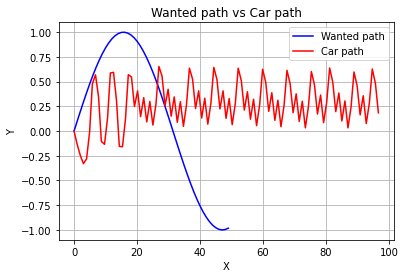

In [226]:
import numpy as np

class Car:
    def __init__(self, x, y, yaw, speed):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.speed = speed

    def update_state(self, delta_yaw, speed):
        self.yaw += delta_yaw
        self.x += self.speed * np.cos(self.yaw)
        self.y += self.speed * np.sin(self.yaw)
        self.speed = speed

def stanley_control(car, path_x, path_y, path_yaw, k):
    error_x = path_x - car.x
    error_y = path_y - car.y
    error_yaw = path_yaw - car.yaw
    
    cross_track_error = error_x * np.sin(car.yaw) - error_y * np.cos(car.yaw)
    yaw_error = np.arctan2(error_y, error_x) - car.yaw
    
    if car.speed < 0:
        yaw_error = np.pi - yaw_error
        
    steering_angle = yaw_error + np.arctan2(k * cross_track_error, car.speed)
    
    return steering_angle

import numpy as np
import matplotlib.pyplot as plt

# ... (Car class and stanley_control function)

def simulate_car_movement(car, path_x, path_y, path_yaw, k=0.5, dt=0.1, max_simulation_time=100.0):
    car_trajectory = []
    time = 0.0
    target_idx = 0
    
    while time <= max_simulation_time:
        if target_idx < len(path_x) - 1:
            distance_to_target = np.hypot(path_x[target_idx] - car.x, path_y[target_idx] - car.y)
            if distance_to_target < 0.5:
                target_idx += 1
                
        stanley_steering_angle = stanley_control(car, path_x[target_idx], path_y[target_idx], path_yaw[target_idx], k)
        car_speed = 1.0  # constant speed
        delta_yaw = stanley_steering_angle * dt
        car.update_state(delta_yaw, car_speed)
        
        car_trajectory.append((car.x, car.y, car.yaw))
        time += dt
        
    return car_trajectory

# Example usage
path_x = np.arange(0, 50, 1)
path_y = np.sin(0.1 * path_x)
path_yaw = np.arctan2(np.gradient(path_y), np.gradient(path_x))

initial_car_x, initial_car_y, initial_car_yaw = 0.0, 0.0, 0.0
car = Car(initial_car_x, initial_car_y, initial_car_yaw, 0.0)
car_trajectory = simulate_car_movement(car, path_x, path_y, path_yaw, max_simulation_time=10)

# Extract x and y coordinates of the car's trajectory
car_trajectory_x = [pos[0] for pos in car_trajectory]
car_trajectory_y = [pos[1] for pos in car_trajectory]

# Plot the wanted path (blue) and the car's path (red)
plt.figure()
plt.plot(path_x, path_y, "b-", label="Wanted path")
plt.plot(car_trajectory_x, car_trajectory_y, "r-", label="Car path")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Wanted path vs Car path")
plt.grid(True)
plt.show()


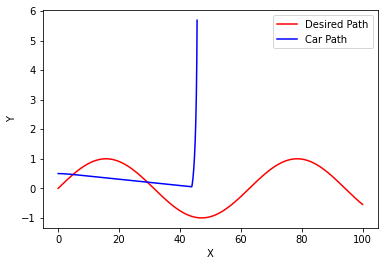

In [200]:
import numpy as np
import matplotlib.pyplot as plt

class Car:
    def __init__(self, x, y, orientation):
        self.x = x
        self.y = y
        self.orientation = orientation

    def next_position(self, steering_angle, speed, dt):
        self.x += speed * np.cos(self.orientation) * dt
        self.y += speed * np.sin(self.orientation) * dt
        self.orientation += speed / L * np.tan(steering_angle) * dt

def controller_algorithm(car, desired_path, lookahead_distance):
    closest_point, closest_distance = None, float("inf")
    for point in desired_path:
        distance = np.sqrt((car.x - point[0])**2 + (car.y - point[1])**2)
        if distance < closest_distance:
            closest_point, closest_distance = point, distance

    lookahead_x, lookahead_y = closest_point
    if lookahead_distance > closest_distance:
        dx = desired_path[-1][0] - car.x
        dy = desired_path[-1][1] - car.y
    else:
        dx = lookahead_x - car.x
        dy = lookahead_y - car.y

    angle_to_lookahead = np.arctan2(dy, dx) - car.orientation
    return angle_to_lookahead

def simulate(car, desired_path, controller, speed, lookahead_distance, dt, num_steps):
    path = [(car.x, car.y)]
    for _ in range(num_steps):
        steering_angle = controller(car, desired_path, lookahead_distance)
        car.next_position(steering_angle, speed, dt)
        path.append((car.x, car.y))
    return path

# Parameters
L = 2.0  # Car wheelbase
speed = 1.0
lookahead_distance = 1.0
dt = 0.1
num_steps = 500

# Desired path (x, y)
desired_path = [(i, np.sin(i/10)) for i in np.linspace(0, 100, 500)]

# Initialize the car with initial position and orientation
car = Car(0.0, 0.5, 0.0)

# Simulate the car's path
car_path = simulate(car, desired_path, controller_algorithm, speed, lookahead_distance, dt, num_steps)

# Plot desired path and car path
plt.figure()
plt.plot([p[0] for p in desired_path], [p[1] for p in desired_path], 'r-', label='Desired Path')
plt.plot([p[0] for p in car_path], [p[1] for p in car_path], 'b-', label='Car Path')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


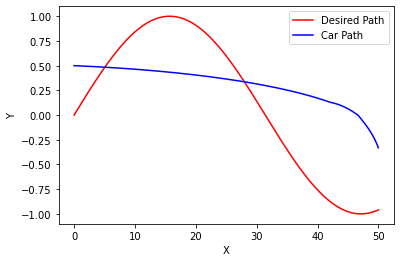

In [213]:
import numpy as np
import matplotlib.pyplot as plt

class Car:
    def __init__(self, x, y, orientation):
        self.x = x
        self.y = y
        self.orientation = orientation

    def next_position(self, steering_angle, speed, dt):
        self.x += speed * np.cos(self.orientation) * dt
        self.y += speed * np.sin(self.orientation) * dt
        self.orientation += speed / L * np.tan(steering_angle) * dt

def controller_algorithm(car, desired_path, lookahead_distance, Kp, Ki, Kd, prev_error, integral):
    closest_point, closest_distance = None, float("inf")
    for point in desired_path:
        distance = np.sqrt((car.x - point[0])**2 + (car.y - point[1])**2)
        if distance < closest_distance:
            closest_point, closest_distance = point, distance

    lookahead_x, lookahead_y = closest_point
    if lookahead_distance > closest_distance:
        dx = desired_path[-1][0] - car.x
        dy = desired_path[-1][1] - car.y
    else:
        dx = lookahead_x - car.x
        dy = lookahead_y - car.y

    angle_to_lookahead = np.arctan2(dy, dx) - car.orientation
    error = angle_to_lookahead

    # PID control
    proportional = Kp * error
    integral += Ki * error * dt
    derivative = Kd * (error - prev_error) / dt
    steering_angle = proportional + integral + derivative

    return steering_angle, error

def simulate(car, desired_path, controller, speed, lookahead_distance, Kp, Ki, Kd, dt, num_steps):
    path = [(car.x, car.y)]
    prev_error = 0
    integral = 0
    for _ in range(num_steps):
        steering_angle, error = controller(car, desired_path, lookahead_distance, Kp, Ki, Kd, prev_error, integral)
        car.next_position(steering_angle, speed, dt)
        path.append((car.x, car.y))
        prev_error = error
    return path

# Parameters
L = 2.0  # Car wheelbase
speed = 1.0
lookahead_distance = 1.0
Kp = 0.01
Ki = 0.01
Kd = 0.2
dt = 0.1
num_steps = 500

# Desired path (x, y)
desired_path = [(i, np.sin(i/10)) for i in np.linspace(0, 50, 500)]

# Initialize the car with initial position and orientation
car = Car(0.0, 0.5, 0.0)

# Simulate the car's path
car_path = simulate(car, desired_path, controller_algorithm, speed, lookahead_distance, Kp, Ki, Kd, dt, num_steps)

# Plot desired path and car path
plt.figure()
plt.plot([p[0] for p in desired_path], [p[1] for p in desired_path], 'r-', label='Desired Path')
plt.plot([p[0] for p in car_path], [p[1] for p in car_path], 'b-', label='Car Path')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


# Use feedforward NN

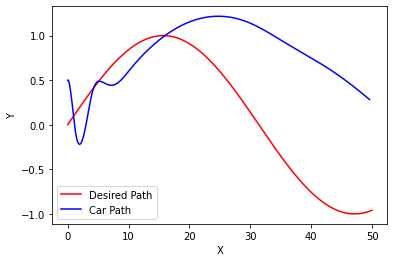

In [218]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

class Car:
    def __init__(self, x, y, orientation):
        self.x = x
        self.y = y
        self.orientation = orientation

    def next_position(self, steering_angle, speed, dt):
        self.x += speed * np.cos(self.orientation) * dt
        self.y += speed * np.sin(self.orientation) * dt
        self.orientation += speed / L * np.tan(steering_angle) * dt

# Neural network model
# Neural network model
class SteeringAngleNN(nn.Module):
    def __init__(self):
        super(SteeringAngleNN, self).__init__()
        self.fc1 = nn.Linear(5, 32)  # Update input size to 5
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def train_nn(model, train_data, epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        for inputs, target in train_data:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

# Generate training data
# Generate training data
def generate_training_data(desired_path, dt, num_steps):
    data = []
    car = Car(0.0, 0.5, 0.0)
    for i in range(1, num_steps):
        dx = desired_path[i][0] - car.x
        dy = desired_path[i][1] - car.y
        angle_to_lookahead = np.arctan2(dy, dx) - car.orientation
        steering_angle = angle_to_lookahead

        inputs = torch.tensor([car.x, car.y, car.orientation, desired_path[i][0], desired_path[i][1]], dtype=torch.float32)
        target = torch.tensor([steering_angle], dtype=torch.float32)
        data.append((inputs, target))

        car.next_position(steering_angle, speed, dt)

    return data


# Parameters
L = 2.0  # Car wheelbase
speed = 1.0
dt = 0.1
num_steps = 500

# Desired path (x, y)
desired_path = [(i, np.sin(i/10)) for i in np.linspace(0, 50, 500)]

# Generate training data
train_data = generate_training_data(desired_path, dt, num_steps)

# Initialize and train the neural network
nn_model = SteeringAngleNN()
train_nn(nn_model, train_data, epochs=200, learning_rate=0.001)

# Simulate the car's path using the neural network
# Simulate the car's path using the neural network
car = Car(0.0, 0.5, 0.0)
car_path = [(car.x, car.y)]
for i in range(1, num_steps):
    inputs = torch.tensor([car.x, car.y, car.orientation, desired_path[i][0], desired_path[i][1]], dtype=torch.float32)
    steering_angle = nn_model(inputs).item()
    car.next_position(steering_angle, speed, dt)
    car_path.append((car.x, car.y))
    
# Plot desired path and car path
plt.figure()
plt.plot([p[0] for p in desired_path], [p[1] for p in desired_path], 'r-', label='Desired Path')
plt.plot([p[0] for p in car_path], [p[1] for p in car_path], 'b-', label='Car Path')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

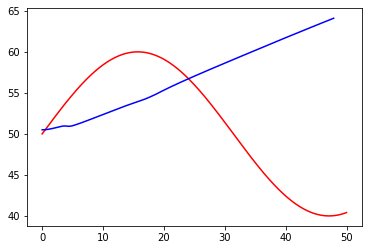

In [220]:
import numpy as np
import matplotlib.pyplot as plt

class Car:
    def __init__(self, x, y, orientation):
        self.x = x
        self.y = y
        self.orientation = orientation

    def next_position(self, steering_angle, speed, dt):
        self.x += speed * np.cos(self.orientation) * dt
        self.y += speed * np.sin(self.orientation) * dt
        self.orientation += speed / L * np.tan(steering_angle) * dt

def gradient_vector_flow(vx, vy, mu, iterations):
    vxx, vxy = np.gradient(vx)
    vyx, vyy = np.gradient(vy)
    for _ in range(iterations):
        vxx, vxy = np.gradient(vx)
        vyx, vyy = np.gradient(vy)
        vx += mu * (vxx + vxy)
        vy += mu * (vyx + vyy)
    return vx, vy

def create_initial_vector_field(desired_path, grid_size):
    vx = np.zeros(grid_size)
    vy = np.zeros(grid_size)
    for i in range(len(desired_path) - 1):
        x1, y1 = desired_path[i]
        x2, y2 = desired_path[i + 1]
        vx[int(y1), int(x1)] = x2 - x1
        vy[int(y1), int(x1)] = y2 - y1
    return vx, vy

def get_steering_angle(car, vx, vy):
    x, y = int(car.y), int(car.x)
    dx, dy = vx[y, x], vy[y, x]
    angle_to_lookahead = np.arctan2(dy, dx) - car.orientation
    return angle_to_lookahead

# Parameters
L = 2.0  # Car wheelbase
speed = 1.0
dt = 0.1
num_steps = 500
grid_size = (100, 100)

# Desired path (x, y)
desired_path = [(i, 50 + 10 * np.sin(i / 10)) for i in np.linspace(0, 50, 500)]

# Create initial vector field and compute gradient vector flow
vx_init, vy_init = create_initial_vector_field(desired_path, grid_size)
vx_gvf, vy_gvf = gradient_vector_flow(vx_init, vy_init, mu=0.1, iterations=100)

# Simulate the car's path using GVF
car = Car(0.0, 50.5, 0.0)
car_path = [(car.x, car.y)]
for _ in range(1, num_steps):
    steering_angle = get_steering_angle(car, vx_gvf, vy_gvf)
    car.next_position(steering_angle, speed, dt)
    car_path.append((car.x, car.y))

# Plot desired path and car path
plt.figure()
plt.plot([p[0] for p in desired_path], [p[1] for p in desired_path], 'r-', label='Desired Path')
plt.plot([p[0] for p in car_path], [p[1] for p in car_path], 'b-', label='Car Path')
plt.xlabel


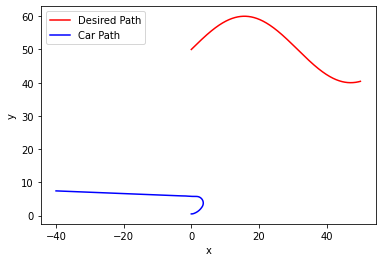

In [224]:
import numpy as np
import matplotlib.pyplot as plt

class Car:
    def __init__(self, x, y, orientation):
        self.x = x
        self.y = y
        self.orientation = orientation

    def next_position(self, steering_angle, speed, dt):
        self.x += speed * np.cos(self.orientation) * dt
        self.y += speed * np.sin(self.orientation) * dt
        self.orientation += speed / L * np.tan(steering_angle) * dt

def discretize_state(car, desired_path, state_bins):
    x_bin = np.digitize(car.x, state_bins[0])
    y_bin = np.digitize(car.y, state_bins[1])
    orientation_bin = np.digitize(car.orientation, state_bins[2])
    desired_x_bin = np.digitize(desired_path[int(car.x)][0], state_bins[0])
    desired_y_bin = np.digitize(desired_path[int(car.x)][1], state_bins[1])
    return x_bin, y_bin, orientation_bin, desired_x_bin, desired_y_bin

def epsilon_greedy_action(q_table, state, actions, epsilon):
    if np.random.random() < epsilon:
        return np.random.choice(len(actions))
    else:
        return np.argmax(q_table[state])

def train_q_learning(q_table, desired_path, actions, state_bins, episodes, alpha, gamma, epsilon, speed, dt):
    for _ in range(episodes):
        car = Car(0.0, 0.5, 0.0)
        state = discretize_state(car, desired_path, state_bins)
        for i in range(1, num_steps):
            action = epsilon_greedy_action(q_table, state, actions, epsilon)
            steering_angle = actions[action]
            car.next_position(steering_angle, speed, dt)
            next_state = discretize_state(car, desired_path, state_bins)
            reward = -np.linalg.norm(np.array((car.x, car.y)) - np.array(desired_path[int(car.x)]))
            q_table[state][action] += alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[state][action])
            state = next_state
    return q_table

# Parameters
L = 2.0  # Car wheelbase
speed = 1.0
dt = 0.1
num_steps = 500

# Desired path (x, y)
desired_path = [(i, 50 + 10 * np.sin(i / 10)) for i in np.linspace(0, 50, num_steps)]

# Q-learning parameters
state_bins = [np.linspace(0, 50, 10),
              np.linspace(40, 60, 10),
              np.linspace(-np.pi, np.pi, 10)]
actions = np.linspace(-np.pi / 4, np.pi / 4, 9)
q_table = np.zeros((len(state_bins[0]) + 1, len(state_bins[1]) + 1, len(state_bins[2]) + 1, len(state_bins[0]) + 1, len(state_bins[1]) + 1, len(actions)))
episodes = 200
alpha = 0.1
gamma = 0.99
epsilon = 0.1

# Train Q-table
q_table = train_q_learning(q_table, desired_path, actions, state_bins, episodes, alpha, gamma, epsilon, speed, dt)
# Simulate the car's path using the trained Q-table
car = Car(0.0, 0.5, 0.0)
car_path = [(car.x, car.y)]
for i in range(1, num_steps):
    state = discretize_state(car, desired_path, state_bins)
    action_index = epsilon_greedy_action(q_table, state, actions, 0)  # Epsilon is set to 0 for using the learned policy
    steering_angle = actions[action_index]
    car.next_position(steering_angle, speed, dt)
    car_path.append((car.x, car.y))

# Plot desired path and car path
plt.figure()
plt.plot([p[0] for p in desired_path], [p[1] for p in desired_path], 'r-', label='Desired Path')
plt.plot([p[0] for p in car_path], [p[1] for p in car_path], 'b-', label='Car Path')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


C:\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 9])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


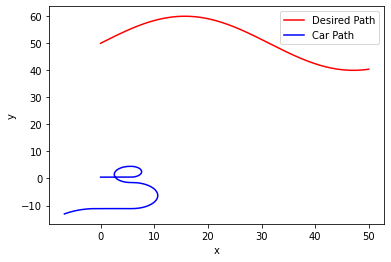

In [225]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

class DQNAgent:
    def __init__(self, input_dim, output_dim, hidden_dim, lr):
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

    def predict(self, state):
        return self.model(state)

    def update(self, state, target):
        self.optimizer.zero_grad()
        loss = self.criterion(self.model(state), target)
        loss.backward()
        self.optimizer.step()

def train_dqn(agent, desired_path, actions, state_bins, episodes, gamma, epsilon, speed, dt, batch_size, buffer_size):
    buffer = deque(maxlen=buffer_size)

    for _ in range(episodes):
        car = Car(0.0, 0.5, 0.0)
        state = discretize_state(car, desired_path, state_bins)
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        for _ in range(num_steps):
            action_index = epsilon_greedy_action(agent, state, actions, epsilon)
            steering_angle = actions[action_index]
            car.next_position(steering_angle, speed, dt)
            next_state = discretize_state(car, desired_path, state_bins)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            reward = -np.linalg.norm(np.array((car.x, car.y)) - np.array(desired_path[int(car.x)]))
            buffer.append((state, action_index, reward, next_state))

            if len(buffer) >= batch_size:
                minibatch = random.sample(buffer, batch_size)
                states, action_indices, rewards, next_states = zip(*minibatch)
                states = torch.cat(states)
                next_states = torch.cat(next_states)
                rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
                actions_mask = torch.tensor(action_indices, dtype=torch.int64).unsqueeze(1)

                q_values = agent.predict(states).gather(1, actions_mask)
                next_q_values = agent.predict(next_states).max(dim=1, keepdim=True)[0].detach()
                target = rewards + gamma * next_q_values

                agent.update(states, target)

            state = next_state
    return agent

def epsilon_greedy_action(agent, state, actions, epsilon):
    if np.random.random() < epsilon:
        return np.random.choice(len(actions))
    else:
        q_values = agent.predict(state).detach()
        return q_values.argmax(dim=1).item()

# DQN parameters
input_dim = 5
output_dim = len(actions)
hidden_dim = 32
lr = 0.001
episodes = 200
gamma = 0.99
epsilon = 0.1
batch_size = 64
buffer_size = 5000

# Train DQN agent
agent = DQNAgent(input_dim, output_dim, hidden_dim, lr)
agent = train_dqn(agent, desired_path, actions, state_bins, episodes, gamma, epsilon, speed, dt, batch_size, buffer_size)

# Simulate the car's path using the trained DQN agent
car = Car(0.0, 0.5, 0.0)
car_path = [(car.x, car.y)]
for i in range(1, num_steps):
    state = discretize_state(car, desired_path, state_bins)
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    action_index = epsilon_greedy_action(agent, state_tensor, actions, 0)  # Epsilon is set to 0 for using the learned policy
    steering_angle = actions[action_index]
    car.next_position(steering_angle, speed, dt)
    car_path.append((car.x, car.y))

# Plot desired path and car path
plt.figure()
plt.plot([p[0] for p in desired_path], [p[1] for p in desired_path], 'r-', label='Desired Path')
plt.plot([p[0] for p in car_path], [p[1] for p in car_path], 'b-', label='Car Path')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


# My method of optimization

-0.7071067811865475


(-1.0, 4.0)

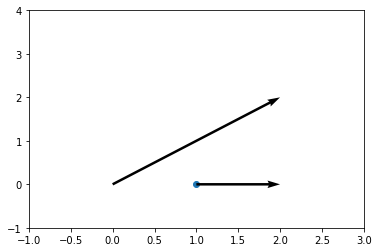

In [313]:
import numpy
from numpy.linalg import norm
#hyper parameters
ka = 1
kd = 1
w = 1
b = 0
learning_rate = 1
#initiate state
class car():
    def __init__(initial_position, direction, velocity):
        self.position = np.array(initial_position)
        self._theta = direction
        self.velocity = velocity
        
    def get_veclocity_vector(self):
        return self.velocity*np.array([np.cos(self._theta), np.sin(self._theta)])
    
    def next_position(self, dt):
        return self.position + self.get_velocity_vector()*dt
    
    def update_position(self, dt):
        self.position = self.next_position(dt)

itterations = 2        
theta=0
for t in range(itterations)
p1 = np.array([0,0])
p2 = np.array([1,1])
velocity = 1
vt = velocity*np.array([np.cos(theta), np.sin(theta)])
dt = 1
p = p2-p1
px = p[0]
py = p[1]
theta_p = np.tan(py/px)
#current position at time t
ct = (1, 0)
n = np.array([-p[0], p[1]])
n_hat = n/norm(n)
#cn is the next position at t+1
delta_pos = vt*dt
cn = ct+delta_pos
d = abs(n_hat@cn)
linear_term = -1*w*d+b
exp = np.exp(linear_term)
#calculate loss
theta_error = abs(theta_p-theta)
loss_angle = ka*theta_error*exp
loss_d = kd*d
#calculate loss gradient
grad_ld = (kd*dt/norm(n))*np.sign(n@vt)*(px*np.cos(theta)+py*np.sin(theta))
dtheta_error = np.sign(theta_p-theta)
grad_la = ka*(exp*dtheta_error)+dtheta_error*linear_term*exp*-1*w*(grad_ld/kd)
grad = grad_ld+grad_la
new_theta = theta+learning_rate*grad
print(new_theta)
plt.scatter(ct[0], ct[1])
plt.quiver(p1[0], p1[1], p2[0], p2[1], angles='xy', scale_units='xy', scale=0.5)
plt.quiver(ct[0], ct[1], vt[0], vt[1], angles='xy', scale_units='xy', scale=1)
plt.xlim([-1, 3])
plt.ylim([-1, 4])
# plt.scatter(*zip(*path))
# plt.scatter(*zip(*viacle_path))
# plt.scatter(init_point[0], init_point[1])
# plt.quiver(path[t][0], path[t][1], vt[0], vt[1], angles='xy', scale_units='xy', scale=1)

In [43]:
class Car():
    def __init__(self, initial_position, direction, velocity):
        self.position = np.array(initial_position)
        self._theta = direction
        self.velocity = velocity

    def set_direction(self, theta):
        self._theta = theta
    
    def get_direction(self):
        return self._theta
        
    def get_velocity_vector(self):
        return self.velocity*np.array([np.cos(self._theta), np.sin(self._theta)])
    
    def next_position(self, dt):
        return self.position + self.get_velocity_vector()*dt
    
    def update_position(self, dt):
        self.position = self.next_position(dt)
        
def plot_vec(point, vec):
    point = np.array(point)
    vec = np.array(vec)
    projection = point+vec
    plt.plot(point[0], point[1], 'ro', label='Point')
    plt.plot(projection[0], projection[1], 'go', label='Projection')
    # Plot the vector from the point to the projection
    plt.arrow(point[0], point[1], projection[0] - point[0], projection[1] - point[1], width=0.01, color='m', label='Vector')

def plot_line(p1,p2,x_scale):
    p1 = np.array(p1)
    p2 = np.array(p2)
    p = p2-p1
    x_min = x_scale[0]
    x_max = x_scale[1]
    x = np.linspace(x_min, x_max)
    if (p1[0]-p2[0]) != 0:
        m = (p1[1]-p2[1])/(p1[0]-p2[0])
        y = m*(x-p1[0])+p1[1]
        plt.plot(x,y, '--')
    else:
        y = np.ones(len(x))*p1[1]
        plt.plot(x,y, '--')

def plot_path(path):
    for t in range(len(path)-1):
        p1 = path[t]
        p2 = path[t+1]
        p = np.array([p1[0], p2[0]])
        plot_line(p1,p2,p)
        
# path = np.array([[1,0], [2,1], [4,5],[6,5]])
# plot_path(path)

## distance term

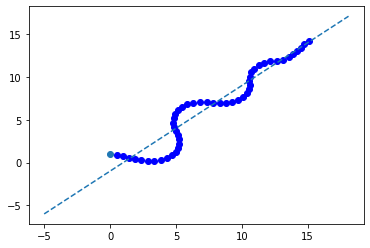

In [75]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline
#hyper parameters
kd = 1
learning_rate = 0.5

#initial parameters
initial_pos = np.array([0,1])
p1 = np.array([1,0])
p2 = np.array([2,1])
p = p2-p1
n = np.array([-p[1],p[0]])
n_hat = n/norm(n)
pt = initial_pos
dt = 0.5
initial_velocity = 1
initial_theta = 0

car = Car(initial_pos, initial_theta, initial_velocity)

# positions = [initial_pos]
losses = []
plt.scatter(initial_pos[0], initial_pos[1])

for t in range(50):
    theta = car.get_direction()
    velocity = car.velocity
    v_hat = np.array([np.cos(theta), np.sin(theta)])
    v = velocity*v_hat
    p_next = car.next_position(dt)
    c = p1-p_next
    d_tilda = c@n_hat
    d = abs(d_tilda)
    ld_grad = velocity*dt*np.sign(d_tilda)*(n_hat[0]*np.sin(theta)-n_hat[1]*np.cos(theta))
    new_theta = theta-learning_rate*ld_grad
    loss_d = d
    losses.append(d)
    
    car.set_direction(new_theta)
    p_next = car.next_position(dt)
    car.update_position(dt)
    plt.scatter(p_next[0], p_next[1], c='b')
    


last_position = car.position

plot_line(p1,p2,[-5,last_position[0]+3])

Text(0.5, 1.0, 'distance loss')

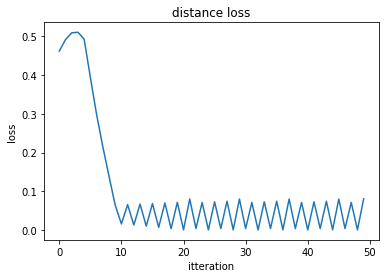

In [86]:
losses = np.array(losses)
plt.plot(losses)
plt.xlabel("itteration")
plt.ylabel("loss")
plt.title("distance loss")

## usign curretn distance

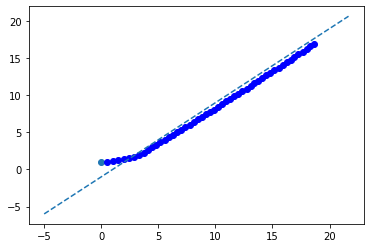

In [93]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline
#hyper parameters
kd = 1
learning_rate = 0.1
w = 0.5

#initial parameters
initial_pos = np.array([0,1])
p1 = np.array([1,0])
p2 = np.array([2,1])
p = p2-p1
n = np.array([-p[1],p[0]])
n_hat = n/norm(n)
pt = initial_pos
dt = 0.5
initial_velocity = 1
initial_theta = 0

car = Car(initial_pos, initial_theta, initial_velocity)
losses = []
# positions = [initial_pos]
plt.scatter(initial_pos[0], initial_pos[1])

for t in range(50):
    pt = car.position.copy()
    theta = car.get_direction()
    velocity = car.velocity
    v_hat = np.array([np.cos(theta), np.sin(theta)])
    v = velocity*v_hat
    p_next = car.next_position(dt)
    c = p1-p_next
    d_tilda = c@n_hat
    d = abs(d_tilda)
    
    theta_l = np.arctan(p[1]/p[0])
    theta_error_tilda = theta-theta_l
    theta_error = abs(theta_error_tilda)
    ct = p1 - pt
    distance_t_tilda = ct@n_hat
    distance_t = abs(theta_error_tilda)
    
    
    
    ld_grad = velocity*dt*np.sign(d_tilda)*(n_hat[0]*np.sin(theta)-n_hat[1]*np.cos(theta))
    la_grad = np.exp(-w*distance_t)*np.sign(theta_error_tilda)
    
    loss_d = d
    loss_angle = theta_error*np.exp(-w*d)
    losses.append(loss_angle)
    
    new_theta = theta-learning_rate*la_grad
    
    car.set_direction(new_theta)
    p_next = car.next_position(dt)
    car.update_position(dt)
    plt.scatter(p_next[0], p_next[1], c='b')
    




last_position = car.position

plot_line(p1,p2,[-5,last_position[0]+3])

Text(0.5, 1.0, 'angle loss')

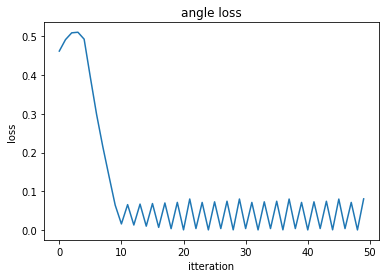

In [94]:
losses = np.array(losses)
plt.plot(losses)
plt.xlabel("itteration")
plt.ylabel("loss")
plt.title("angle loss")

## Combain the losses

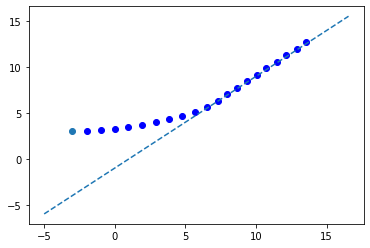

In [104]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline
#hyper parameters
kd = 0.5
ka = 1
w = 1/5

learning_rate = 0.1


#initial parameters
initial_pos = np.array([0,1])
initial_pos = np.array([-3,3])
p1 = np.array([1,0])
p2 = np.array([2,1])
p = p2-p1
n = np.array([-p[1],p[0]])
n_hat = n/norm(n)
pt = initial_pos
dt = 1
initial_velocity = 1
initial_theta = 0

car = Car(initial_pos, initial_theta, initial_velocity)
losses = []
# positions = [initial_pos]
plt.scatter(initial_pos[0], initial_pos[1])

for t in range(20):
    pt = car.position.copy()
    theta = car.get_direction()
    velocity = car.velocity
    v_hat = np.array([np.cos(theta), np.sin(theta)])
    v = velocity*v_hat
    p_next = car.next_position(dt)
    c = p1-p_next
    d_tilda = c@n_hat
    d = abs(d_tilda)
    
    theta_l = np.arctan(p[1]/p[0])
    theta_error_tilda = theta-theta_l
    theta_error = abs(theta_error_tilda)
    ct = p1 - pt
    distance_t_tilda = ct@n_hat
    distance_t = abs(theta_error_tilda)
    
    
    
    ld_grad = velocity*dt*np.sign(d_tilda)*(n_hat[0]*np.sin(theta)-n_hat[1]*np.cos(theta))
    la_grad = np.exp(-w*distance_t)*np.sign(theta_error_tilda)
    grad = ka*la_grad+kd*ld_grad
    
    loss_d = d
    loss_angle = theta_error*np.exp(-w*d)
    loss = ka*loss_angle+kd*loss_d
    losses.append(loss)
    
    new_theta = theta-learning_rate*grad
    
    car.set_direction(new_theta)
    p_next = car.next_position(dt)
    car.update_position(dt)
    plt.scatter(p_next[0], p_next[1], c='b')
    



last_position = car.position

plot_line(p1,p2,[-5,last_position[0]+3])

Text(0.5, 1.0, 'loss')

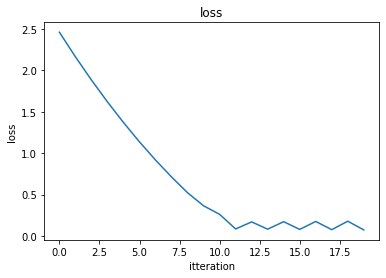

In [105]:
losses = np.array(losses)
plt.plot(losses)
plt.xlabel("itteration")
plt.ylabel("loss")
plt.title("loss")

## Now try path

In [1]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline
class Car():
    def __init__(self, initial_position, direction, velocity):
        self.position = np.array(initial_position)
        self._theta = direction
        self.velocity = velocity

    def set_direction(self, theta):
        self._theta = theta
    
    def get_direction(self):
        return self._theta
        
    def get_velocity_vector(self):
        return self.velocity*np.array([np.cos(self._theta), np.sin(self._theta)])
    
    def next_position(self, dt):
        return self.position + self.get_velocity_vector()*dt
    
    def update_position(self, dt):
        self.position = self.next_position(dt)
        
def plot_vec(point, vec):
    point = np.array(point)
    vec = np.array(vec)
    projection = point+vec
    plt.plot(point[0], point[1], 'ro', label='Point')
    plt.plot(projection[0], projection[1], 'go', label='Projection')
    # Plot the vector from the point to the projection
    plt.arrow(point[0], point[1], projection[0] - point[0], projection[1] - point[1], width=0.05, color='m', label='Vector')

def plot_line(p1,p2,x_scale):
    p1 = np.array(p1)
    p2 = np.array(p2)
    p = p2-p1
    x_min = x_scale[0]
    x_max = x_scale[1]
    x = np.linspace(x_min, x_max)
    if p1[1]-p2[1] != 0:
        m = (p1[1]-p2[1])/(p1[0]-p2[0])
        y = m*(x-p1[0])+p1[1]
        plt.plot(x,y, '--')
    else:
        y = np.ones(len(x))*p1[1]
        plt.plot(x,y, '--')

def plot_path(path):
    for t in range(len(path)-1):
        p1 = path[t]
        p2 = path[t+1]
        p = np.array([p1[0], p2[0]])
        plot_line(p1,p2,p)
        
# path = np.array([[1,0], [2,1], [4,5],[6,5]])
# plot_path(path)

def point_distance(p1, p2):
    return norm(p2-p1)

def line_point_distance(p1, p2, point):
    p = p2-p1
    n = np.array([-p[1],p[0]])
    n_hat = n/norm(n)
    return point@n_hat
    
def passed_section(p1, p2, point):
    p = p2-p1
    p3 = p2-point
    return p@p3 < 0

def distance_to_end_section(p1, p2, point):
    p = p2-p1
    p_hat = p/norm(p)
    p3 = p2-point
    return p_hat@p3


def find_next_section(path, position,current_index, threshold):
    if current_index == len(path)-2:
        return current_index
    have_passed_section = passed_section(path[current_index], path[current_index+1], position)
    if  have_passed_section:
        return current_index + 1
    if (not have_passed_section) and (distance_to_end_section(path[current_index], path[current_index+1], position) < threshold):
        return current_index + 1
    return current_index



In [12]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline


def simulation(loss_ratio , w, end_section_threshold, learning_rate, path,initial_pos, initial_velocity, initial_theta, dt, max_itteration):
    #hyper parameters
#     loss_ratio = 0.8
    kd = loss_ratio
    ka = 1-loss_ratio
    w = 1
#     end_section_threshold = 1
#     learning_rate = 1


    #initial parameters
#     path = np.array([initial_pos, [1,0], [2,1], [4,5],[6,5]])


#     initial_pos = np.array([0,0])
    pt = initial_pos
#     dt = 0.1
#     initial_velocity = 1
#     initial_theta = 0

    car = Car(initial_pos, initial_theta, initial_velocity)
    losses = []
    # positions = [initial_pos]
    plt.scatter(initial_pos[0], initial_pos[1])
    car_path = []

    i = 0
    for t in range(max_itteration):
        #if got to the end
        if i == len(path)-2 and passed_section(path[i], path[i+1], pt):
            break

        i = find_next_section(path, pt,i, end_section_threshold)


        p1 = path[i]
        p2 = path[i+1]
        p = p2-p1
        n = np.array([-p[1],p[0]])
        n_hat = n/norm(n)

        pt = car.position.copy()
        theta = car.get_direction()
        velocity = car.velocity




        v_hat = np.array([np.cos(theta), np.sin(theta)])
        v = velocity*v_hat
        p_next = car.next_position(dt)
        c = p1-p_next
        d_tilda = c@n_hat
        d = abs(d_tilda)

        theta_l = np.arctan(p[1]/p[0])
        theta_error_tilda = theta-theta_l
        theta_error = abs(theta_error_tilda)
        ct = p1 - pt
        distance_t_tilda = ct@n_hat
        distance_t = abs(theta_error_tilda)



        ld_grad = velocity*dt*np.sign(d_tilda)*(n_hat[0]*np.sin(theta)-n_hat[1]*np.cos(theta))
        la_grad = np.exp(-w*distance_t)*np.sign(theta_error_tilda)
        grad = ka*la_grad+kd*ld_grad

        loss_d = d
        loss_angle = theta_error*np.exp(-w*d)
        loss = ka*loss_angle+kd*loss_d
        losses.append(loss)

        new_theta = theta-learning_rate*grad

        car.set_direction(new_theta)
        p_next = car.next_position(dt)
        car.update_position(dt)
        car_path.append(p_next)
    car_path = np.array(car_path)
    plt.plot(car_path[:,0], car_path[:,1])
#         plt.scatter(p_next[0], p_next[1], c='b', s=0.5)




    last_position = car.position


    plot_path(path)


## path

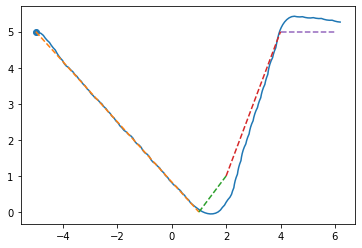

In [36]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline
#hyper parameters
loss_ratio = 0.8
kd = loss_ratio
ka = 1-loss_ratio
w = 10
end_section_threshold = 0.5
initial_velocity = 1
dt = 0.1
learning_rate = w*dt*initial_velocity

initial_pos = np.array([-5,5])
#initial parameters
path = np.array([initial_pos, [1,0], [2,1], [4,5],[6,5]])

loss_ratio = 0.8

pt = initial_pos

initial_theta = 0 #np.pi/2
simulation(loss_ratio , w, end_section_threshold, learning_rate, path,initial_pos, initial_velocity, initial_theta, dt, 1000)

array([5., 0.])

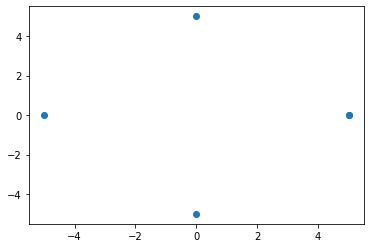

In [38]:
r = 5
theta = np.linspace(0, 2*np.pi, 5)
x = r*np.cos(theta)
y = r*np.sin(theta)
circle_path = np.array([x, y]).transpose()

plt.scatter(*zip(*circle_path))
circle_path[0]

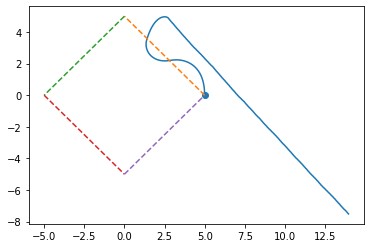

In [39]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline
#hyper parameters
loss_ratio = 0.8
kd = loss_ratio
ka = 1-loss_ratio
w = 1
end_section_threshold = 1
learning_rate = 1


#initial parameters
path = circle_path

loss_ratio = 0.8
initial_pos = np.array([5,0])
pt = initial_pos
dt = 0.05
initial_velocity = 1
initial_theta = np.pi/2
simulation(loss_ratio , w, end_section_threshold, learning_rate, path,initial_pos, initial_velocity, initial_theta, dt, 500)

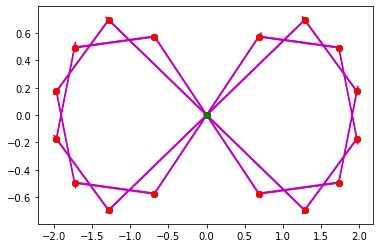

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def infinity_sign(radius):
    theta = np.linspace(-np.pi, np.pi, 10)
    x = radius * np.sin(theta)
    y = radius * np.sin(theta) * np.cos(theta) / (1 + np.sin(theta) ** 2)
    path1 = np.column_stack((x, y))
    path2 = np.column_stack((x, -y))
    return np.concatenate([path1, path2])

# Generate the infinity sign path
infinity = infinity_sign(2)
plt.scatter(*zip(*infinity))
path = infinity
points = path[:-1]
vecs = path[1:]-path[:-1]
for point, vec in  zip(points, vecs):
    plot_vec(point, vec)


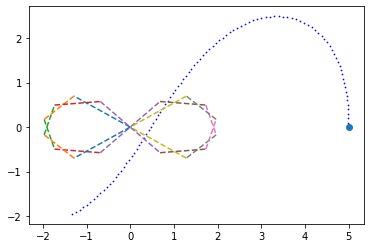

In [32]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline
#hyper parameters
loss_ratio = 0.8
kd = loss_ratio
ka = 1-loss_ratio
w = 1
end_section_threshold = 1
learning_rate = 1


#initial parameters
path = infinity

loss_ratio = 0.8
initial_pos = np.array([5,0])
pt = initial_pos
dt = 0.1
initial_velocity = 1
initial_theta = np.pi/2
simulation(loss_ratio , w, end_section_threshold, learning_rate, path,initial_pos, initial_velocity, initial_theta, dt, 100)

# Trapezoidal velocity profile